In [22]:
# SETUP
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
import numpy as np
import json
import requests
import pandas as pd

QRELS_FILE = "../qrels.txt"
QUERY_URL = "http://localhost:8983/solr/books/select?defType=edismax&indent=true&q.op=OR&q=artificial%20intelligence%20categories%3Acomputers%5E2&qf=book_title%5E2%20reviews.text%20reviews.summary%20description&rows=40&stopwords=false&useParams="

"""
q = artificial intelligence categories:computers^2
q.op = or

defType = edismax
qf = book_title^2 reviews.text reviews.summary description

"""


# Read qrels to extract relevant documents
relevant = list(map(lambda el: el.strip(), open(QRELS_FILE).readlines()))
# Get query results from Solr instance
results = requests.get(QUERY_URL).json()['response']['docs']


In [23]:
# METRICS TABLE
# Define custom decorator to automatically calculate metric based on key
metrics = {}
metric = lambda f: metrics.setdefault(f.__name__, f)

@metric
def ap(results, relevant):
    """Average Precision"""
    precision_values = []
    relevant_count = 0

    for idx, doc in enumerate(results):
        if doc['id'] in relevant:
            relevant_count += 1
            precision_at_k = relevant_count / (idx + 1)
            precision_values.append(precision_at_k)

    if not precision_values:
        return 0.0

    return sum(precision_values)/len(precision_values)

@metric
def p10(results, relevant, n=10):
    """Precision at N"""
    return len([doc for doc in results[:n] if doc['id'] in relevant])/n

def calculate_metric(key, results, relevant):
    return metrics[key](results, relevant)

# Define metrics to be calculated
evaluation_metrics = {
    'ap': 'Average Precision',
    'p10': 'Precision at 10 (P@10)'
}

# Calculate all metrics and export results as LaTeX table
df = pd.DataFrame([['Metric','Value']] +
                  [
                      [evaluation_metrics[m], calculate_metric(m, results, relevant)]
                      for m in evaluation_metrics
                  ]
                  )

with open('results.tex','w') as tf:
    tf.write(df.to_latex())


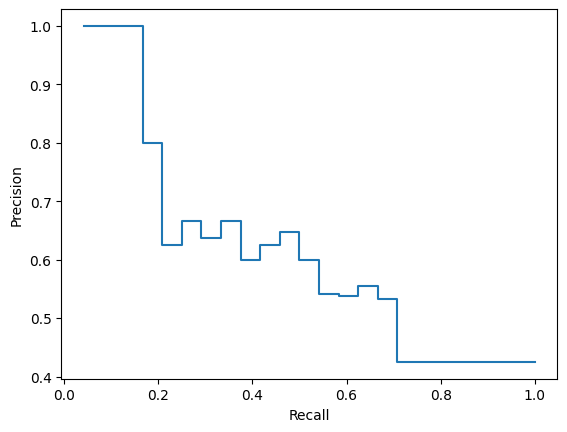

In [24]:
# PRECISION-RECALL CURVE
# Calculate precision and recall values as we move down the ranked list
precision_values = [
    len([
        doc
        for doc in results[:idx]
        if doc['id'] in relevant
    ]) / idx
    for idx, _ in enumerate(results, start=1)
]

recall_values = [
    len([
        doc for doc in results[:idx]
        if doc['id'] in relevant
    ]) / len(relevant)
    for idx, _ in enumerate(results, start=1)
]

precision_recall_match = {k: v for k,v in zip(recall_values, precision_values)}

# Extend recall_values to include traditional steps for a better curve (0.1, 0.2 ...)
recall_values.extend([step for step in np.arange(0.1, 1.1, 0.1) if step not in recall_values])
recall_values = sorted(set(recall_values))

# Extend matching dict to include these new intermediate steps
for idx, step in enumerate(recall_values):
    if step not in precision_recall_match:
        if recall_values[idx-1] in precision_recall_match:
            precision_recall_match[step] = precision_recall_match[recall_values[idx-1]]
        else:
            precision_recall_match[step] = precision_recall_match[recall_values[idx+1]]

disp = PrecisionRecallDisplay([precision_recall_match.get(r) for r in recall_values], recall_values)
disp.plot()
plt.savefig('precision_recall.pdf')
